# Hyperparameter Tuning in PyTorch

In this notebook we will demonstrate how to set up and execute distributed hyperparameter tuning across multiple CPUs and GPUs in PyTorch. If using an HPC system, the current examples are limited to a single node/machine.

In [1]:
import torch

# Get the number of CPU threads PyTorch can see
num_cpus = torch.get_num_threads()
print(f"Number of CPU threads: {num_cpus}")

# Check how many GPUs are available
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("Using CPU")


Number of CPU threads: 14
Using CPU


## Create surrogate data

In [2]:
import sklearn.datasets as sdt

# Create surogate data
n_samples = 1000
n_features = 100
n_info = 5
n_targets = 3
noise = 20

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 100), Shape of y: (1000, 3)


## Preprocess data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Get the normalizers using the sklearn library
x_normalizer, y_normalizer = StandardScaler(), StandardScaler()

# Fit the normalizers
x_normalizer.fit(x)
y_normalizer.fit(y)

# Normalize the data
x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

## Initialize Ray Tuner

In [4]:
# Do the tuning with ray
import ray
from torch.utils.data import DataLoader, TensorDataset

# initialize ray
ray.shutdown()
ray.init()

print("Available resources:", ray.cluster_resources())

batch_size = 32

# Create the data holder for training/validation (the test set should be held separate from any model training)
dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
dataset_val = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).float())

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, pin_memory=True)

# Put the large objects into the Ray object store
dl_train_id = ray.put(dataloader)
dl_val_id = ray.put(dataloader_val)

x_val_id = ray.put(x_val)
y_val_id = ray.put(y_val_real)
y_normalizer_id = ray.put(y_normalizer)

2024-09-18 11:03:02,566	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Available resources: {'CPU': 14.0, 'memory': 21529983386.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}


## Create PyTorch Model

In [5]:
import torch
import torch.nn as nn

# Build a pytorch model
class ArtificialNeuralNetwork(nn.Module):
    def __init__(
        self,
        num_features,
        num_outputs,
        node_list = [8, 8, 8],
        act_fun = "relu",
        dropout = 0.0,
        input_dropout = 0.0,
        batch_norm = False,
        l2_reg = 0.0,
        **kwargs,
    ):
        super(ArtificialNeuralNetwork, self).__init__(**kwargs)
        
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.node_list = node_list
        self.act_fun = act_fun
        self.dropout = dropout
        self.input_dropout = input_dropout
        self.batch_norm = batch_norm
        self.l2_reg = l2_reg
    
        self.num_layers = len(self.node_list)
        
        # create layer dictionary
        self.layer_dict = nn.ModuleDict()
        
        # Create the layers
        self.create_dropout_layers()
        self.create_activation_layers()
        self.create_batch_norm_layers()
        self.create_output_layer()
        self.create_dense_layers()
        
        
    def get_activation(self, act_name):
        if act_name == "relu":
            return nn.ReLU()
        elif act_name == "tanh":
            return nn.Tanh()
        elif act_name == "leaky_relu":
            return nn.LeakyReLU()
        elif act_name == "elu":
            return nn.ELU()
        else:
            raise ValueError(f"Unsupported activation function {act_name}")
        
    
    def create_dropout_layers(self):
        if self.input_dropout > 0:
            self.layer_dict.update({"input_dropout": nn.Dropout(p=self.input_dropout)})
            
        if self.dropout > 0:
            self.layer_dict.update(
                {
                    f"dropout_{i}": nn.Dropout(p=self.dropout)
                    for i in range(self.num_layers)
                }
            )
            
    def create_activation_layers(self):
        if self.act_fun:
            self.layer_dict.update(
                {
                    f"activation_{i}": self.get_activation(self.act_fun)
                    for i in range(self.num_layers)
                }
            )
            
    def create_batch_norm_layers(self):
        if self.batch_norm:
            self.layer_dict.update(
                {
                    f"batch_norm_{i}": nn.BatchNorm1d(
                        num_features=self.node_list[i],
                        affine=True,
                        track_running_stats=True,
                        momentum=1e-2,
                        eps=1e-3,
                    )
                    for i in range(self.num_layers)
                }
            )
            
    def create_output_layer(self):
        self.layer_dict.update(
            {
                "output": nn.Linear(
                    in_features=self.num_features if not self.node_list else self.node_list[-1], 
                    out_features=self.num_outputs,
                )
            }
        
        )
        
    def create_dense_layers(self):
        self.layer_dict.update(
            {
                f"dense_{i}": nn.Linear(
                    in_features=(
                        self.num_features if i == 0 else self.node_list[i - 1]
                    ),
                    out_features=self.node_list[i],
                )
                for i in range(self.num_layers)
            }
        )
        
    def l2_regularization(self, lambda_l2: float):
        l2_norm = sum(
            p.pow(2.0).sum()
            for name, p in self.named_parameters()
            if p.requires_grad and "weight" in name
        )
        return 0.5 * lambda_l2 * l2_norm
    
    def forward(self, inputs):
        
        # Apply input dropout
        x = (
            self.layer_dict["input_dropout"](inputs)
            if self.input_dropout > 0
            else inputs
        )
        
        # Apply dense block
        for i in range(self.num_layers):
            x = self.layer_dict[f"dense_{i}"](x)
            x = self.layer_dict[f"batch_norm_{i}"](x) if self.batch_norm else x
            x = self.layer_dict[f"activation_{i}"](x) if self.act_fun else x
            x = self.layer_dict[f"dropout_{i}"](x) if self.dropout > 0 else x
        
        
        # Apply the output layer
        return self.layer_dict["output"](x)
    
    def fit(self, train_dl, val_dl, optimizer, criterion, num_epochs: int, device="cpu", verbose=False):
        
        self.to(device)

        # Create history dictionary
        if not hasattr(self, "history"):
            self.history = {"loss": [], "val_loss": []}

        for epoch in range(num_epochs):
            # Put model in training mode
            self.train()
            running_loss = 0.0

            for x_in, y_in in train_dl:
                x_in = x_in.to(device)
                y_in = y_in.to(device)

                # Forward pass
                pred = self(x_in)
                loss = criterion(pred, y_in)

                # Add L2 regularization if present
                if self.l2_reg > 0:
                    loss += self.l2_regularization(lambda_l2=self.l2_reg)

                # Zero the parameter gradients
                optimizer.zero_grad()
                # Backward pass
                loss.backward()
                # Optimize
                optimizer.step()
                # Print statistics
                running_loss += loss.item() * x_in.size(0)

            # Normalize loss
            running_loss /= len(train_dl.dataset)

            # Put model in evaluation mode
            self.eval()
            # Compute validation loss
            running_val_loss = 0.0
            with torch.no_grad():
                for x_val, y_val in val_dl:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    pred_val = self(x_val)
                    val_loss = criterion(pred_val, y_val)
                    running_val_loss += val_loss.item() * y_in.size(0)

            running_val_loss /= len(val_dl.dataset)

            # Print statistics
            if (epoch + 1) % 10 == 0 and verbose:
                print(
                    f"Epoch {epoch + 1}, Loss: {running_loss:.4f}, "
                    f"Val Loss: {running_val_loss:.4f}"
                )

            # Save history
            self.history["loss"].append(running_loss)
            self.history["val_loss"].append(running_val_loss)

## Create Ray Model Tune Functions

In [6]:
from torch import optim

def model_builder(config):
    act_fun = config["act_fun"]
    dropout = config["dropout"]
    input_dropout = config["input_dropout"]
    batch_norm = config["batch_norm"]
    l2_reg = config["l2_reg"]

    max_depth = config["max_depth"]
    if config["node_list"] is None:
        node_list = [config[f"layer_{i}_width"] for i in range(max_depth) if config[f"layer_{i}_width"] > 0]

    else:
        node_list = config["node_list"]

    # Remove zero width layers
    node_list = [x for x in node_list if x > 0]
    
    learning_rate = config["learning_rate"]
    
    loss = "mse"
    
    if loss == "mse":
        criterion = nn.MSELoss(reduction="mean")
        
    # if torch.cuda.is_available():
    #     device = torch.device("cuda")
    # else:
    #     device = torch.device("cpu")
    
    model = ArtificialNeuralNetwork(
        num_features=x_train.shape[1],
        num_outputs=y_train.shape[1],
        node_list=node_list,
        act_fun=act_fun,
        dropout=dropout,
        input_dropout=input_dropout,
        batch_norm=batch_norm,
        l2_reg=l2_reg,
    )
#     model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, optimizer, criterion

def tune_model(config):
    
    dl_train = ray.get(dl_train_id)
    dl_val = ray.get(dl_val_id)
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    # print(f"Device: {device}")
    
    model, optimizer, criterion = model_builder(config)
    
    model.fit(
        train_dl=dl_train,
        val_dl=dl_val,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=200,
        device=device,
    )
    
    val_loss = model.history['val_loss'][-1]
    
    return {"val_loss": val_loss}

### Quick test that the model is working

In [7]:
# test
import time
from torchinfo import summary

s_time = time.time()

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

model, optimizer, crit = model_builder(
    {
        "act_fun": "relu",
        "dropout": 0.1,
        "input_dropout": 0.1,
        "batch_norm": False,
        "l2_reg": 0.0,
        "learning_rate": 1e-3,
        "node_list": [32, 32],
        # "node_list": [],
        "max_depth": 2,
    }
)
print(summary(model, input_size=(batch_size, x_train.shape[1]), device=device))

model.fit(
    train_dl=dataloader,
    val_dl=dataloader_val,
    optimizer=optimizer,
    criterion=crit,
    num_epochs=200,
    device=device,
    verbose=True,
)

print(f"Elapsed time: {time.time() - s_time}")

Using CPU
Layer (type:depth-idx)                   Output Shape              Param #
ArtificialNeuralNetwork                  [32, 3]                   --
├─ModuleDict: 1-1                        --                        --
│    └─Dropout: 2-1                      [32, 100]                 --
│    └─Linear: 2-2                       [32, 32]                  3,232
│    └─ReLU: 2-3                         [32, 32]                  --
│    └─Dropout: 2-4                      [32, 32]                  --
│    └─Linear: 2-5                       [32, 32]                  1,056
│    └─ReLU: 2-6                         [32, 32]                  --
│    └─Dropout: 2-7                      [32, 32]                  --
│    └─Linear: 2-8                       [32, 3]                   99
Total params: 4,387
Trainable params: 4,387
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.14
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Si

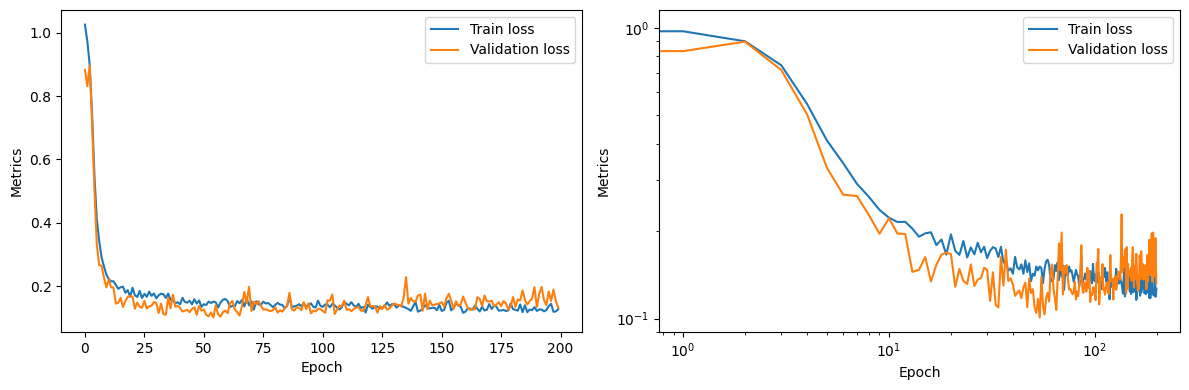

In [8]:
from ptmelt.utils.visualization import plot_history
history = model.history
plot_history(history, plot_log=True)

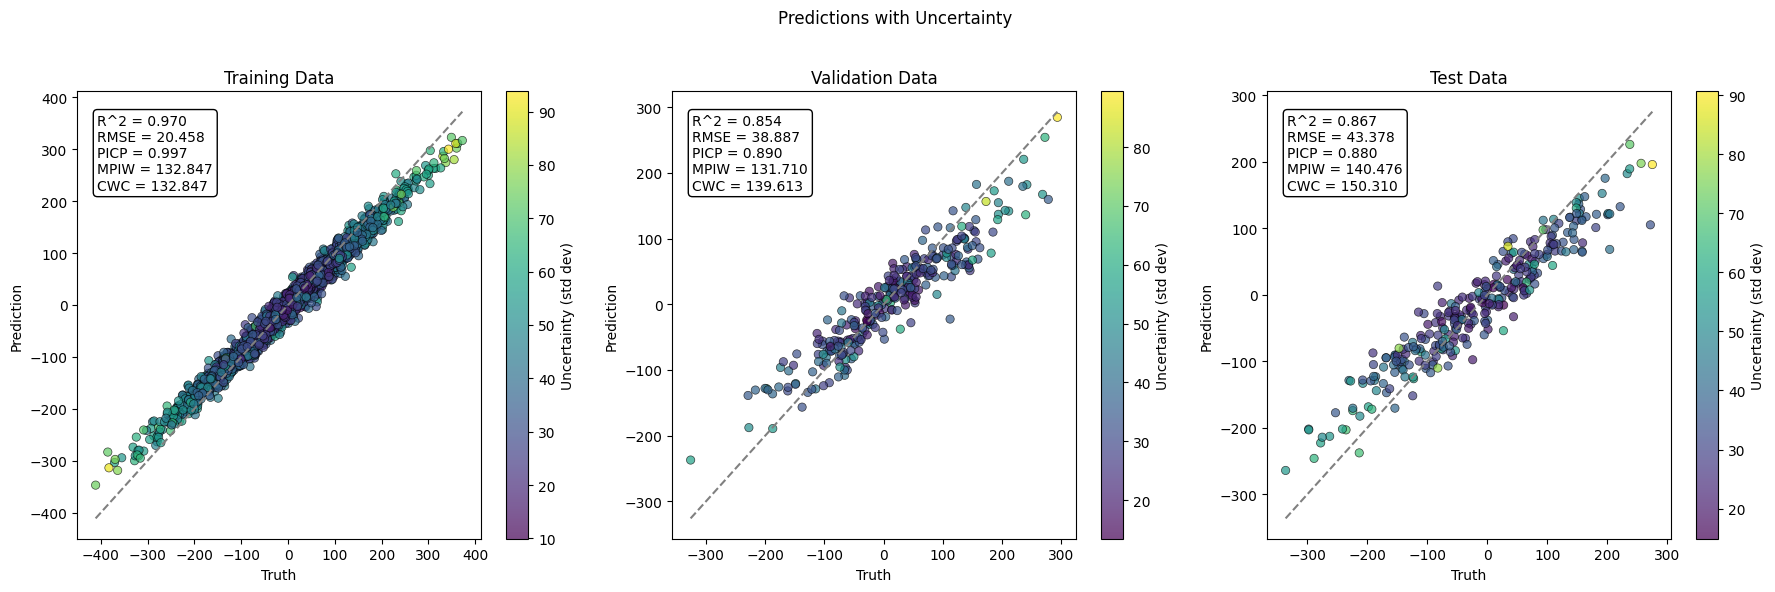

In [9]:
from ptmelt.utils.evaluation import ensemble_predictions
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Necessary to be consistent with pt-melt prediction routines
model.num_mixtures = 0
ensmeble_size = 100
training = True # needed for monte carlo dropout evaluation
####

pred_mean_train, pred_std_train = ensemble_predictions(model, x_train, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training) 
pred_mean_test, pred_std_test = ensemble_predictions(model, x_test, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)
pred_mean_val, pred_std_val = ensemble_predictions(model, x_val, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)

plot_predictions_with_uncertainty(
    pred_mean_train, pred_std_train, y_train_real,
    pred_mean_val, pred_std_val, y_val_real,
    pred_mean_test, pred_std_test, y_test_real,
    metrics_to_display=["R^2", "RMSE", "PICP", "MPIW", "CWC"],
)

## Set hyperparameter variables

In [10]:
import random
import numpy as np
from ray import tune
from ray.tune.schedulers import ASHAScheduler

# Create a list of dropout values
dropout_values = np.arange(0, 0.55, 0.05).tolist()
node_values = [0, 8, 32, 128, 512]

max_depth = 3

config = {
    "act_fun": tune.choice(["relu", "elu"]),
    "batch_norm": tune.choice([True, False]),
    # "l2_reg": tune.choice([0.0, 1e-3]),
    "l2_reg": 0.0,
    "learning_rate": tune.choice([1e-3, 3e-4, 1e-4]),
    "dropout": tune.choice(dropout_values),
    "input_dropout": tune.choice(dropout_values),
    # "node_list":tune.choice([[32, 32], [64, 64], [128, 128], [256, 256]]),
    # "max_depth": 2,
    **{f"layer_{i}_width": tune.choice(node_values) for i in range(max_depth)},
    "max_depth": max_depth,
    "node_list": None,
}

asha = ASHAScheduler(
    metric="val_loss",
    mode="min",
    max_t=200,  # Maximum number of epochs
    grace_period=10, # Number of epochs to wait before stopping a trial
    reduction_factor=2,
)

## Run the tuner

In [11]:
asha_analysis = tune.run(
    tune.with_parameters(tune_model),
    config=config,
    num_samples=256,
    scheduler=asha,
    verbose=1,
    # resources_per_trial={"cpu": 1, "gpu": 1},
    resources_per_trial={"cpu": 1, "gpu": 0},
)

2024-09-18 11:05:34,939	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/nwimer/ray_results/tune_model_2024-09-18_11-03-06' in 0.0752s.
2024-09-18 11:05:34,966	INFO tune.py:1041 -- Total run time: 148.43 seconds (148.31 seconds for the tuning loop).


## Get the best model parameters from the tuning

In [12]:
best_asha = asha_analysis.get_best_config(metric="val_loss", mode="min")
print("Best hyperparameters found were: ", best_asha)

Best hyperparameters found were:  {'act_fun': 'elu', 'batch_norm': False, 'l2_reg': 0.0, 'learning_rate': 0.0003, 'dropout': 0.15000000000000002, 'input_dropout': 0.0, 'layer_0_width': 0, 'layer_1_width': 512, 'layer_2_width': 512, 'max_depth': 3, 'node_list': None}


## Build the model from the best hyperparameters and train from scratch

In [13]:
best_model, optimizer, crit = model_builder(best_asha)

print(summary(best_model, input_size=(batch_size, x_train.shape[1]), device=device))

best_model.fit(
    train_dl=dataloader,
    val_dl=dataloader_val,
    optimizer=optimizer,
    criterion=crit,
    num_epochs=200,
    device=device,
    verbose=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
ArtificialNeuralNetwork                  [32, 3]                   --
├─ModuleDict: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 512]                 51,712
│    └─ELU: 2-2                          [32, 512]                 --
│    └─Dropout: 2-3                      [32, 512]                 --
│    └─Linear: 2-4                       [32, 512]                 262,656
│    └─ELU: 2-5                          [32, 512]                 --
│    └─Dropout: 2-6                      [32, 512]                 --
│    └─Linear: 2-7                       [32, 3]                   1,539
Total params: 315,907
Trainable params: 315,907
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 10.11
Input size (MB): 0.01
Forward/backward pass size (MB): 0.26
Params size (MB): 1.26
Estimated Total Size (MB): 1.54
Epoch 10, Loss: 0.0622, Val Loss: 0.0669
Epoch 20, Loss

## Evaluate the model performance

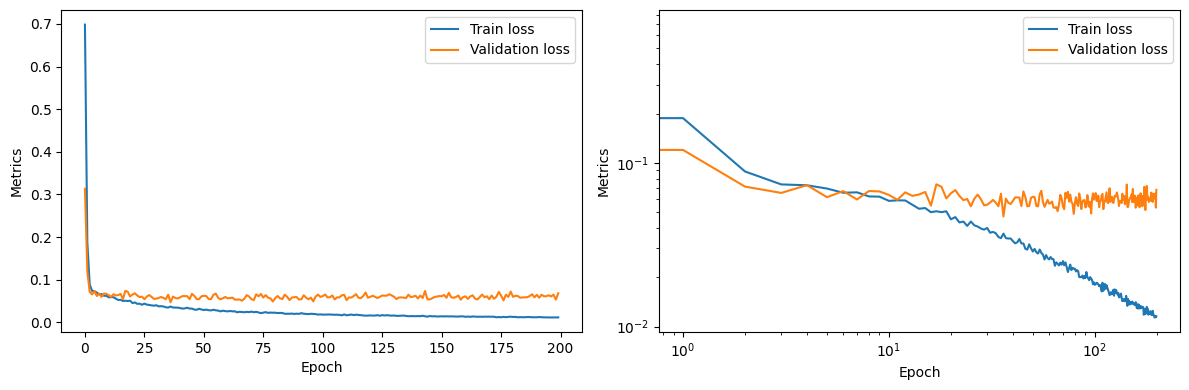

In [14]:
from ptmelt.utils.visualization import plot_history
history = best_model.history
plot_history(history, plot_log=True)

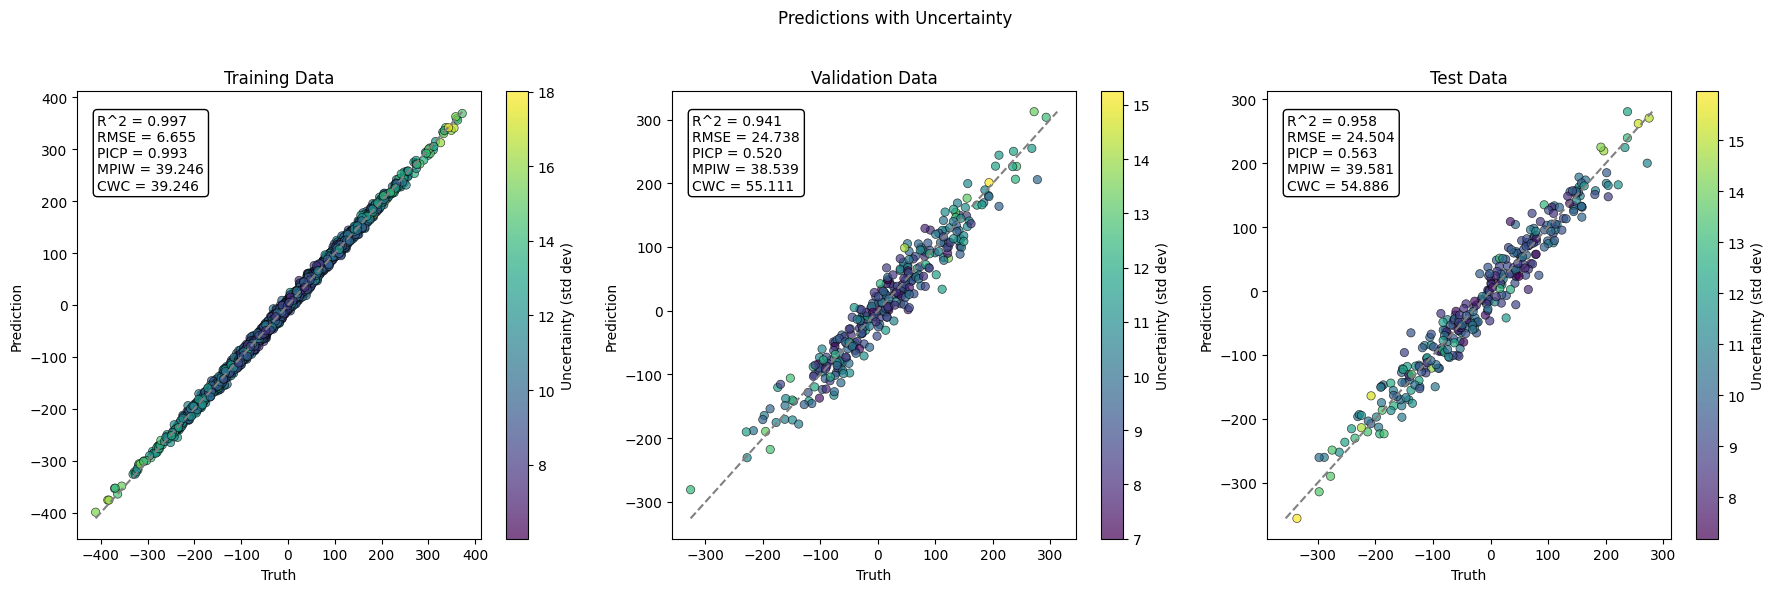

In [15]:
from ptmelt.utils.evaluation import ensemble_predictions
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Necessary to be consistent with pt-melt prediction routines
best_model.num_mixtures = 0
ensmeble_size = 100
training = True # needed for monte carlo dropout evaluation
####

pred_mean_train, pred_std_train = ensemble_predictions(best_model, x_train, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training) 
pred_mean_test, pred_std_test = ensemble_predictions(best_model, x_test, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)
pred_mean_val, pred_std_val = ensemble_predictions(best_model, x_val, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)

plot_predictions_with_uncertainty(
    pred_mean_train, pred_std_train, y_train_real,
    pred_mean_val, pred_std_val, y_val_real,
    pred_mean_test, pred_std_test, y_test_real,
    metrics_to_display=["R^2", "RMSE", "PICP", "MPIW", "CWC"],
)

## Try modifying the hyperparameter fit function

In [16]:
from ptmelt.utils.statistics import compute_cwc, compute_picp

def tune_model(config):
    
    dl_train = ray.get(dl_train_id)
    dl_val = ray.get(dl_val_id)
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    # print(f"Device: {device}")
    
    model, optimizer, criterion = model_builder(config)
    
    model.fit(
        train_dl=dl_train,
        val_dl=dl_val,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=200,
        device=device,
    )
    
    val_loss = model.history['val_loss'][-1]

    # Add in UQ metric as objective
    x_val = ray.get(x_val_id)
    y_val_real = ray.get(y_val_id)
    y_normalizer = ray.get(y_normalizer_id)

    pred_mean_val, pred_std_val = ensemble_predictions(model, x_val.copy(), y_normalizer=y_normalizer, unnormalize=True, n_iter=100, training=True)
    val_cwc = compute_cwc(y_val_real, pred_mean_val, pred_std_val)

    val_picp = compute_picp(y_val_real, pred_mean_val, pred_std_val)

    return {"val_loss": val_loss, "val_cwc": val_cwc, "val_picp": val_picp}

In [17]:
asha_cwc = ASHAScheduler(
    # metric="val_cwc",
    # mode="min",
    # metric="val_loss",
    metric="val_picp",
    mode="max",
    max_t=200,  # Maximum number of epochs
    grace_period=10, # Number of epochs to wait before stopping a trial
    reduction_factor=3,
)

In [18]:
asha_analysis = tune.run(
    tune.with_parameters(tune_model),
    config=config,
    num_samples=256,
    scheduler=asha_cwc,
    verbose=1,
    # resources_per_trial={"cpu": 1, "gpu": 1},
    resources_per_trial={"cpu": 1, "gpu": 0},
)

2024-09-18 11:08:14,482	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/nwimer/ray_results/tune_model_2024-09-18_11-05-42' in 0.0714s.
2024-09-18 11:08:14,510	INFO tune.py:1041 -- Total run time: 151.54 seconds (151.43 seconds for the tuning loop).


In [19]:
best_asha = asha_analysis.get_best_config(metric="val_loss", mode="min")
print("Best hyperparameters found were: ", best_asha)

Best hyperparameters found were:  {'act_fun': 'elu', 'batch_norm': False, 'l2_reg': 0.0, 'learning_rate': 0.0003, 'dropout': 0.35000000000000003, 'input_dropout': 0.0, 'layer_0_width': 0, 'layer_1_width': 32, 'layer_2_width': 32, 'max_depth': 3, 'node_list': None}


In [20]:
best_model, optimizer, crit = model_builder(best_asha)

print(summary(best_model, input_size=(batch_size, x_train.shape[1]), device=device))

best_model.fit(
    train_dl=dataloader,
    val_dl=dataloader_val,
    optimizer=optimizer,
    criterion=crit,
    num_epochs=200,
    device=device,
    verbose=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
ArtificialNeuralNetwork                  [32, 3]                   --
├─ModuleDict: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 32]                  3,232
│    └─ELU: 2-2                          [32, 32]                  --
│    └─Dropout: 2-3                      [32, 32]                  --
│    └─Linear: 2-4                       [32, 32]                  1,056
│    └─ELU: 2-5                          [32, 32]                  --
│    └─Dropout: 2-6                      [32, 32]                  --
│    └─Linear: 2-7                       [32, 3]                   99
Total params: 4,387
Trainable params: 4,387
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.14
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
Epoch 10, Loss: 0.5677, Val Loss: 0.5208
Epoch 20, Loss: 0.2942, V

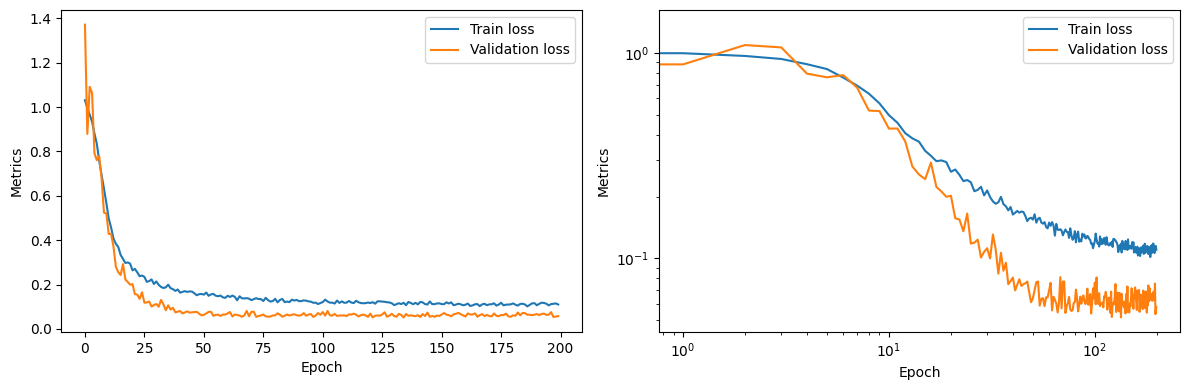

In [21]:
from ptmelt.utils.visualization import plot_history
history = best_model.history
plot_history(history, plot_log=True)

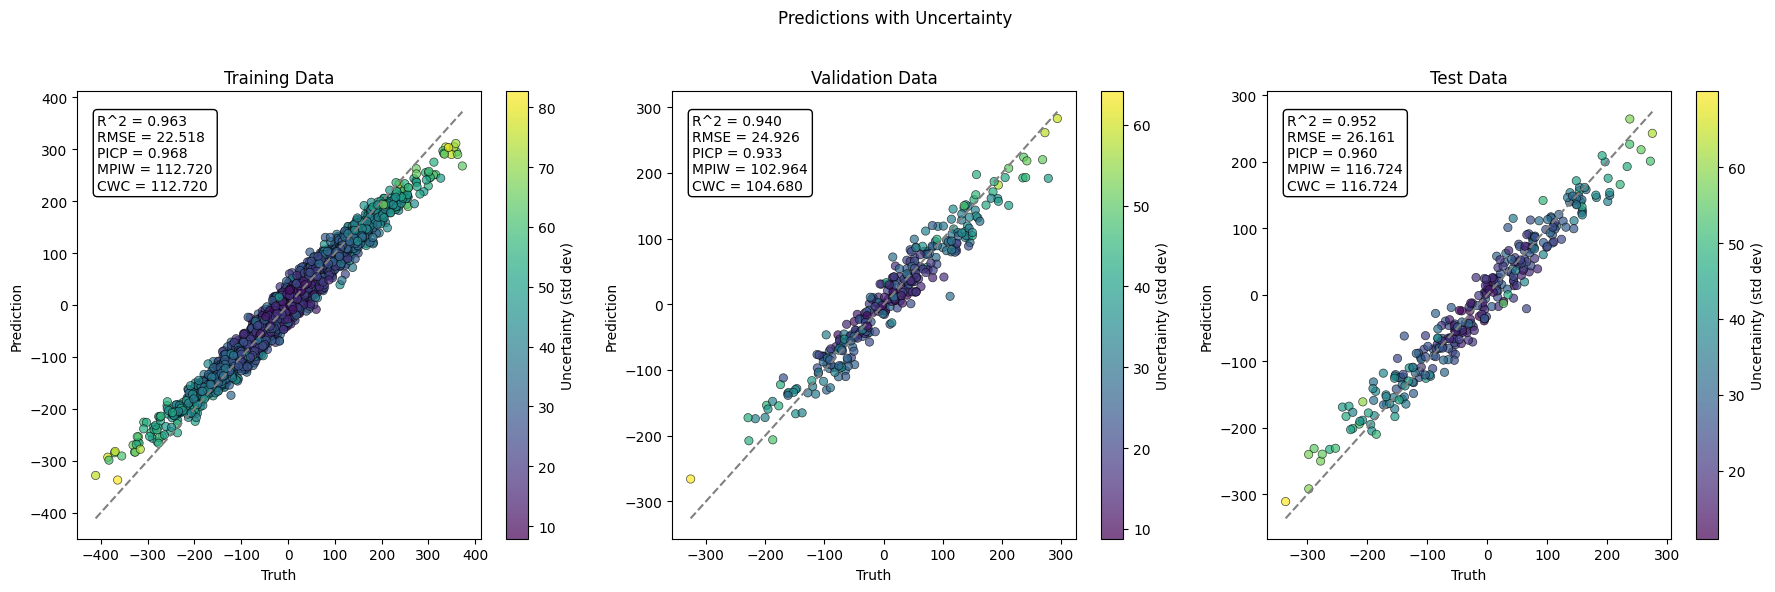

In [22]:
from ptmelt.utils.evaluation import ensemble_predictions
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Necessary to be consistent with pt-melt prediction routines
best_model.num_mixtures = 0
ensmeble_size = 100
training = True # needed for monte carlo dropout evaluation
####

pred_mean_train, pred_std_train = ensemble_predictions(best_model, x_train, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training) 
pred_mean_test, pred_std_test = ensemble_predictions(best_model, x_test, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)
pred_mean_val, pred_std_val = ensemble_predictions(best_model, x_val, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)

plot_predictions_with_uncertainty(
    pred_mean_train, pred_std_train, y_train_real,
    pred_mean_val, pred_std_val, y_val_real,
    pred_mean_test, pred_std_test, y_test_real,
    metrics_to_display=["R^2", "RMSE", "PICP", "MPIW", "CWC"],
)